<div align="right"><i>Peter Norvig<br>Dec 2019</i></div>

# Predicting Presidential Electoral Votes from Approval Polls

Various sites aggregate opinion polls on presidential job performance. The polls are broken out state-by-state, month-by-month at [Mourning Consult](https://morningconsult.com/tracking-trump/). Trump's national **net approval** (percent approving minus percent disapproving) is currently  -10% on [RealClearPolitics](https://www.realclearpolitics.com/epolls/other/president_trump_job_approval-6179.html), -13% on  [538](https://projects.fivethirtyeight.com/trump-approval-ratings/), and -16% on [Gallup](https://news.gallup.com/poll/203198/presidential-approval-ratings-donald-trump.aspx).  There are four big caveats in jumping from these numbers to conclusions about the election:

1. Today is not election day 2020. 

2. We don't know who will be on the ballot in 2020.

3. Approval polls are not votes. 

4. Popular votes are not electoral votes. 

I have nothing to offer on the first three points. But can we use state-by-state approval polls to 
predict electoral votes? ***Yes we can!***


# TL;DR: In this model, Trump gets 104 to 235 Electoral Votes

There is a lot of uncertainty, so I won't try to give an exact single number. Rather, I will say that, as of December 2019, under the assumption that Trump wins the electoral votes of states where he currently has positive net approval and loses the states where he has negative net approval:
- His mean expected number of electoral votes is 149.5.
- He has net approval of zero in two big states, Texas and North Carolina, so depending on how they go, the total would be 123 to 176.
- If you allow for a swing of up to 3.5% across the board, then the totals range anywere from 104 to 235.
- Recall that you need 270 to win.
- To reach 270, he'd need to take all the states where he is ahead or tied, plus six states where he is behind, the toughest being Pennsylvania, where he is 5% behind.


# Details for data science nerds

View, verify, or modify **[my code](ElectoralVotesCode.ipynb)**.

In [1]:
%run ElectoralVotesCode.ipynb

EV(states)

149.5

The `.5` indicates a tie (net zero approval) in one or more states. 

To get a better feel for the situation, imagine a swing in voter approval of just 0.5% in either direction, for every state across the board. That would break ties, and we'd get a range of electoral votes. If we allowed larger swings in approval, we'd get a larger range. Here's how it goes:

In [2]:
show_swings()

Swing   EV Range
±0.5%  123 to 176
±1.5%  118 to 205
±2.5%  118 to 224
±3.5%  104 to 235
±4.5%  104 to 253
±5.5%   89 to 286
±6.5%   79 to 290
±7.5%   67 to 290


That is, the `4.5%` row says that if Trump's approval slipped 4.5% in every state, he would suffer a blowout loss, getting only 104 electoral votes. If he gained 4.5% in every state, it would be a close loss with 253 electoral votes (to 285 for the opponent).

# Details for policy wonks

The following plot shows, for each month in office, the expected number of electoral votes, with error bars indicating a 3% approval swing in either direction (that is: the blue diamond is the total number of electoral votes for states where he has net positive approval; the top and bottom of the grey bars give the total if he were to gain or lose 3% in every state. Why 3%? That was the [average error](https://fivethirtyeight.com/features/the-polls-are-all-right/) in national presidential polls in 2016: Clinton was predicted to win the popular vote by 6% but actually only won by 3%.) Trump hasn't been above 270 since 4 months into his term. He's been below 200 for a year.

The most recent month (month 35) is December 2019.

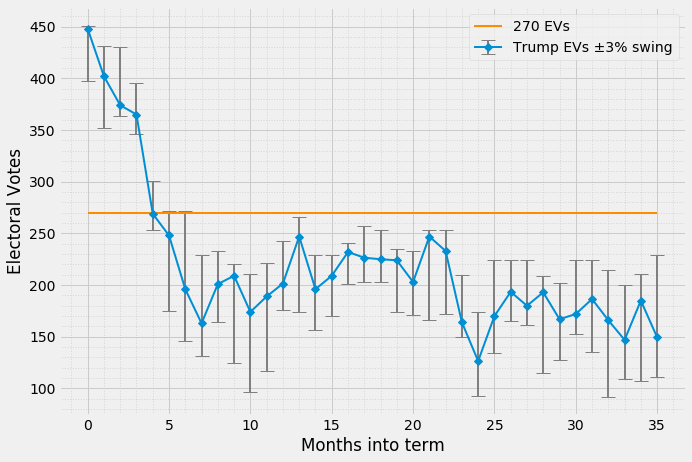

In [3]:
show_evs()

# Uncertainty

There's a lot of uncertainty. We don't know who  will be on the ballot and what their approval levels will be, we don't know if there is systematic bias in the polling data, we don't know who will decide not to vote, we don't know who will be prevented or dissuaded from voting by interference foreign or domestic, we don't know if future events will change voters' perceptions. In what follows, I assume there is no big event (or events) that makes a dramatic change in the public perception of candidates; rather, just the normal range of change in approval as tracked over the last 3 years of Trump's presidency. I have five ways of understanding the fluidity of the situation:

- **Undecided**: Undecided voters could make up their minds late in the election cycle. But there are few undecided voters: in most states, only 3% or 4%. 

- **Variance**: How much are voters changing their minds from month to month in each state?  I track the standard deviation, 𝝈, of the net approval for each state over the last 12 months (variance is the square of standard deviation).

- **Movement**: I define the **maximum expected movement** of approval as 1/5 of the undecided voters (i.e., assume the undecided voters broke 60/40 one way or the other) plus 2 standard deviations in the monthly net approval. 

- **Swing state**: I define a swing state as one whose maximum expected movement is greater than the absolute value of the net approval. There are **12** such states now.  The swing states are shown below in **BOLD CAPS**.

- **Margin**: If you list states in order of net approval, the key turning-point state is Pennsylvania; Trump would need to win that and every state in which he is more popular to reach 270. He currently is **5% behind in Pennsylvania**, so we say that his margin is just over 5%.

# State-by-state summary table

The following table packs in a lot of information. States are sorted by net approval. The columns are:

- **State**: name of state. 
- **Net**: President's current net approval in state.
- **Move**:  Expected maximum movement: 1/5 of the undecided voters  plus 2 standard deviations in the net approval over the last 12 months.
- **EV**: State's number of electoral votes.
- **ΣEV**: Cumulative running sum of electoral votes of this state and all states above.
- **+**: President's current approval in state.
- **-**: President's current disapproval in state.
- **?**: Undecideds in state.
- **𝝈**: Standard deviation in net approval over the past 12 months in state.

The table shows that:
- If Trump wins the states he is leading or tied in, he gets **176** electoral votes (the **ΣEV** in the TEXAS row).
- If he also wins all the swing states, he gets **235** electoral votes (**ΣEV** in the ARIZONA row). 
- To get to **270**, he would also need to win Ohio and Pennsylvania. 
- He is currently down by **5%** in Pennsylvania, so that's the margin.
- Some traditional swing states currently seem out of reach for Trump: he's at **-15%** in Michigan and **-9%** in Wisconsin.


In [4]:
show_states()

|State|Net|Move|EV|ΣEV|+|−|?|𝝈|
|-|-|-|-|-|-|-|-|-|
|Wyoming|+28%|±11%|3|3|62%|34%|4%|±5.0%
|Alabama|+22%|±6%|9|12|59%|37%|4%|±2.4%
|West Virginia|+21%|±5%|5|17|59%|38%|3%|±2.1%
|Idaho|+16%|±5%|4|21|56%|40%|4%|±2.2%
|Tennessee|+15%|±5%|11|32|56%|41%|3%|±2.2%
|Kentucky|+14%|±4%|8|40|55%|41%|4%|±1.5%
|Mississippi|+14%|±7%|6|46|55%|41%|4%|±3.0%
|Arkansas|+10%|±5%|6|52|53%|43%|4%|±1.9%
|Louisiana|+9%|±7%|8|60|53%|44%|3%|±3.3%
|Oklahoma|+8%|±6%|7|67|52%|44%|4%|±2.5%
|Kansas|+7%|±5%|6|73|52%|45%|3%|±2.3%
|**UTAH**|**+7%**|**±8%**|6|79|52%|45%|3%|±3.6%
|**MISSOURI**|**+6%**|**±6%**|10|89|51%|45%|4%|±2.7%
|**NORTH DAKOTA**|**+5%**|**±5%**|3|92|51%|46%|3%|±2.4%
|South Carolina|+5%|±5%|9|101|51%|46%|3%|±2.1%
|**SOUTH DAKOTA**|**+5%**|**±7%**|3|104|51%|46%|3%|±3.2%
|Indiana|+3%|±3%|11|115|50%|47%|3%|±1.2%
|**MONTANA**|**+3%**|**±7%**|3|118|50%|47%|3%|±3.0%
|**NEBRASKA**|**+1%**|**±7%**|5|123|49%|48%|3%|±3.4%
|**NORTH CAROLINA**|**+0%**|**±4%**|15|138|48%|48%|4%|±1.6%
|**TEXAS**|**+0%**|**±4%**|38|176|48%|48%|4%|±1.7%
|**FLORIDA**|**-1%**|**±3%**|29|205|48%|49%|3%|±1.4%
|**ALASKA**|**-2%**|**±7%**|3|208|47%|49%|4%|±3.2%
|**GEORGIA**|**-2%**|**±6%**|16|224|47%|49%|4%|±2.5%
|**ARIZONA**|**-3%**|**±4%**|11|235|47%|50%|3%|±1.8%
|Ohio|-4%|±2%|18|253|46%|50%|4%|±0.8%
|Pennsylvania|-5%|±3%|20|273|46%|51%|3%|±1.4%
|Virginia|-5%|±4%|13|286|46%|51%|3%|±1.8%
|Maine|-6%|±5%|4|290|46%|52%|2%|±2.4%
|Iowa|-9%|±4%|6|296|44%|53%|3%|±1.9%
|Wisconsin|-9%|±5%|10|306|44%|53%|3%|±2.1%
|New Mexico|-10%|±7%|5|311|43%|53%|4%|±3.2%
|Minnesota|-11%|±5%|10|321|43%|54%|3%|±2.3%
|Nevada|-12%|±5%|6|327|42%|54%|4%|±2.3%
|Delaware|-15%|±8%|3|330|41%|56%|3%|±3.5%
|Michigan|-15%|±5%|16|346|40%|55%|5%|±1.9%
|New Jersey|-15%|±4%|14|360|41%|56%|3%|±1.5%
|Colorado|-18%|±6%|9|369|39%|57%|4%|±2.5%
|New Hampshire|-19%|±6%|4|373|39%|58%|3%|±2.7%
|Oregon|-20%|±5%|7|380|38%|58%|4%|±2.2%
|Connecticut|-21%|±3%|7|387|38%|59%|3%|±1.1%
|Illinois|-22%|±4%|20|407|37%|59%|4%|±1.6%
|Rhode Island|-23%|±4%|4|411|37%|60%|3%|±1.8%
|Maryland|-24%|±5%|10|421|36%|60%|4%|±2.1%
|New York|-25%|±3%|29|450|36%|61%|3%|±1.3%
|Washington|-25%|±4%|12|462|36%|61%|3%|±1.6%
|California|-28%|±3%|55|517|34%|62%|4%|±1.3%
|Hawaii|-28%|±9%|4|521|34%|62%|4%|±4.2%
|Massachusetts|-31%|±4%|11|532|33%|64%|3%|±1.8%
|Vermont|-35%|±8%|3|535|31%|66%|3%|±3.6%
|District of Columbia|-58%|±6%|3|538|19%|77%|4%|±2.6%

# Margin and country-wide net approval by month

The next plot gives the swing margin needed to reach 270 for each month, along with the country-wide net approval. Trump has been in negative territory on all metrics since his fourth month in office. He's been net -10% or worse country-wide every month since his third in office.  We see that the state-by-state margin roughly correlates with the country-wide net approval, but not exactly.

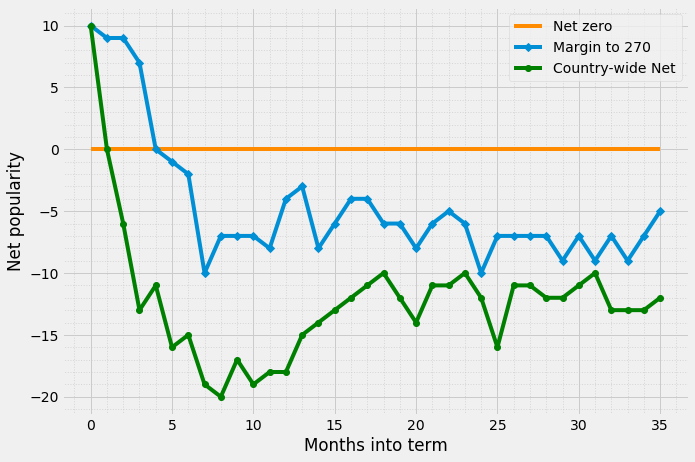

In [5]:
show_approval()

# Popularity Above Replacement President (PARP) 

Fivethirtyeight is a combination sports/politics site, and it has a lot of statistics about sports players and how much better they are than the average replacement player. Given that, they [decided](https://fivethirtyeight.com/features/the-states-where-trump-is-more-and-less-popular-than-he-should-be/) to rate the president's approval versus each state's overall approval of the president's party (in recent elections), which is a way of rating the president's performance versus an average replacement candidate from the same party. I'll duplicate that work and keep it up to date. We define the PARP for a state as the president's net approval minus the average party-member's net approval in that state (known as the "partisan lean"). 

In the table below, states are ordered by PARP. In each row we have the state name followed by the partisan lean of the state (positive numbers lean towards the president's party), the electoral votes, and then a pair of statistics (PARP, and net approval (in parentheses)) for four time periods (today,  followed by January of 2019, 2018, and 2017). Trump was more popular than an average Republican at his inauguration in January 2017, with positive PARP in 42 states. But by 2018 he had positive PARP in only 6 states, and today only 2, Hawaii and Rhode Island, where he is deeply unpopular, but not quite as unpopular as other Republicans.

In [6]:
show_parp()

|State|Lean|EV|PARP|(Net)|PARP'19|(Net)|PARP'18|(Net)|PARP'17|(Net)|
|-|-|-|-|-|-|-|-|-|-|-|
|Hawaii|-36|4|+8|(-28)|+7|(-29)|+0|(-36)|+23|(-13)|
|Rhode Island|-26|4|+3|(-23)|+7|(-19)|+4|(-22)|+22|(-4)|
|Delaware|-14|3|-1|(-15)|-1|(-15)|+0|(-14)|+22|(+8)|
|Maine|-5|4|-1|(-6)|-6|(-11)|-11|(-16)|+13|(+8)|
|Maryland|-23|10|-1|(-24)|-7|(-30)|+0|(-23)|+10|(-13)|
|Mississippi|+15|6|-1|(+14)|-2|(+13)|+2|(+17)|+19|(+34)|
|Massachusetts|-29|11|-2|(-31)|-2|(-31)|-3|(-32)|+25|(-4)|
|New Jersey|-13|14|-2|(-15)|-6|(-19)|-3|(-16)|+15|(+2)|
|New Mexico|-7|5|-3|(-10)|-11|(-18)|-13|(-20)|+24|(+17)|
|New York|-22|29|-3|(-25)|-2|(-24)|+4|(-18)|+30|(+8)|
|California|-24|55|-4|(-28)|-6|(-30)|+1|(-23)|+18|(-6)|
|Alabama|+27|9|-5|(+22)|-7|(+20)|+3|(+30)|+9|(+36)|
|**NORTH CAROLINA**|+5|15|-5|(+0)|-9|(-4)|-6|(-1)|+13|(+18)|
|Virginia|+0|13|-5|(-5)|-10|(-10)|-4|(-4)|+8|(+8)|
|**FLORIDA**|+5|29|-6|(-1)|-9|(-4)|+0|(+5)|+17|(+22)|
|Pennsylvania|+1|20|-6|(-5)|-11|(-10)|-4|(-3)|+9|(+10)|
|Louisiana|+17|8|-8|(+9)|-2|(+15)|+2|(+19)|+14|(+31)|
|Illinois|-13|20|-9|(-22)|-10|(-23)|-8|(-21)|+22|(+9)|
|Kentucky|+23|8|-9|(+14)|-9|(+14)|-8|(+15)|+11|(+34)|
|Minnesota|-2|10|-9|(-11)|-16|(-18)|-12|(-14)|+5|(+3)|
|West Virginia|+30|5|-9|(+21)|-6|(+24)|-8|(+22)|+7|(+37)|
|Connecticut|-11|7|-10|(-21)|-13|(-24)|-8|(-19)|+16|(+5)|
|Wisconsin|+1|10|-10|(-9)|-17|(-16)|-13|(-12)|+5|(+6)|
|Ohio|+7|18|-11|(-4)|-13|(-6)|-11|(-4)|+7|(+14)|
|Oregon|-9|7|-11|(-20)|-13|(-22)|-11|(-20)|+11|(+2)|
|Vermont|-24|3|-11|(-35)|-11|(-35)|-12|(-36)|+22|(-2)|
|**ARIZONA**|+9|11|-12|(-3)|-17|(-8)|-12|(-3)|+11|(+20)|
|South Carolina|+17|9|-12|(+5)|-9|(+8)|-10|(+7)|+8|(+25)|
|**MISSOURI**|+19|10|-13|(+6)|-21|(-2)|-17|(+2)|+0|(+19)|
|Nevada|+1|6|-13|(-12)|-14|(-13)|-2|(-1)|+9|(+10)|
|Tennessee|+28|11|-13|(+15)|-16|(+12)|-11|(+17)|+5|(+33)|
|Washington|-12|12|-13|(-25)|-14|(-26)|-11|(-23)|+13|(+1)|
|Arkansas|+24|6|-14|(+10)|-14|(+10)|-11|(+13)|+6|(+30)|
|**GEORGIA**|+12|16|-14|(-2)|-14|(-2)|-5|(+7)|+6|(+18)|
|Michigan|-1|16|-14|(-15)|-14|(-15)|-9|(-10)|+9|(+8)|
|District of Columbia|-43|3|-15|(-58)|-22|(-65)|-21|(-64)|+12|(-31)|
|Indiana|+18|11|-15|(+3)|-14|(+4)|-17|(+1)|+4|(+22)|
|Iowa|+6|6|-15|(-9)|-20|(-14)|-16|(-10)|+3|(+9)|
|**MONTANA**|+18|3|-15|(+3)|-17|(+1)|-18|(+0)|+6|(+24)|
|Kansas|+23|6|-16|(+7)|-22|(+1)|-18|(+5)|+1|(+24)|
|**ALASKA**|+15|3|-17|(-2)|-14|(+1)|-14|(+1)|+9|(+24)|
|Colorado|-1|9|-17|(-18)|-17|(-18)|-13|(-14)|+2|(+1)|
|**TEXAS**|+17|38|-17|(+0)|-17|(+0)|-10|(+7)|+3|(+20)|
|Idaho|+35|4|-19|(+16)|-20|(+15)|-24|(+11)|-6|(+29)|
|Wyoming|+47|3|-19|(+28)|-17|(+30)|-22|(+25)|-7|(+40)|
|New Hampshire|+2|4|-21|(-19)|-21|(-19)|-12|(-10)|-1|(+1)|
|**NEBRASKA**|+24|5|-23|(+1)|-24|(+0)|-18|(+6)|-1|(+23)|
|**UTAH**|+31|6|-24|(+7)|-37|(-6)|-34|(-3)|-4|(+27)|
|Oklahoma|+34|7|-26|(+8)|-24|(+10)|-19|(+15)|+0|(+34)|
|**SOUTH DAKOTA**|+31|3|-26|(+5)|-25|(+6)|-21|(+10)|-10|(+21)|
|**NORTH DAKOTA**|+33|3|-28|(+5)|-29|(+4)|-22|(+11)|-10|(+23)|